# Basic pipeline

## Introduction

We'll get started importing `scycle` itself, and from there using single-cell RNA-seq from an Ewing Sarcoma cell line named CHLA9 \[ref\]. `scycle` accepts `AnnData` objects as imputs. In this case, we internally download and the data from a `loom` file, which will also allow us to showcase the integration of the pipeline with `scvelo` and RNA velocity.

In [1]:
import scycle as cc

In [2]:
chla9 = cc.data.get_data('CHLA9')

-- Loading data from cache...


In [3]:
chla9

AnnData object with n_obs × n_vars = 5061 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

## Pre-processing

Though samples can be pre-processed by other pipelines before using `scycle`, we implemented our own pre-processing pipeline. In the `filter_cells` stage, only quality control attempting to deal with low-quality cells is done.

In [4]:
cc.pp.filter_cells(chla9)

3851 cells pass the count filter
4599  cells pass the mt filter
Cells selected 3813


Then, the standard preprocessing recipe for scycle is called `prep_simple`. This recipe performs library size normalization, log2-transformation and selects the most highly varying genes in the dataset. If these steps have already been done in your dataset, you may skip this.

In [5]:
cc.pp.prep_simple(chla9)

Scoring cell cycle...


## Dimensionality reduction

`tl.dimensionality_reduction` reduces the dimensionality of the data, by default, using Principal Component Analysis of cell cycle genes. This reduced dimensionality space should work in most cases to find the cell cycle trajectory.

In [6]:
cc.tl.dimensionality_reduction(chla9)

Dimensionality reduction using PCA...


We can inspect our scycle results visually using the plotting module, but also by looking at the AnnData itself.

In [7]:
chla9

AnnData object with n_obs × n_vars = 3813 × 10000
    obs: 'TotalUMIs', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'G1S_Tirosh', 'G2M_Tirosh', 'G1S_Freeman', 'G2M_Freeman', 'G1S_short', 'G2M_short', 'Histones', 'G1-S', 'G2-M'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'scycle', 'dimRed', 'P_dimRed'
    obsm: 'X_dimRed', 'X_pca_scycle'
    layers: 'matrix', 'spliced', 'unspliced'

The previous steps have added multiple layers and variables to the AnnData. Here, we're going to focus on the `obsm`, which are dimensionality reductions. Feel free to take a look at other additions (e.g. `chla9.uns['scycle']` will have the parameters for functions that have run)

In [8]:
chla9.obsm['X_dimRed'].shape, chla9.obsm['X_pca_scycle'].shape

((3813, 30), (3813, 3))

In this case, `X_dimRed` is a 30-D PCA of cell-cycle genes, while `X_pca_scycle` is also a PCA with 3 PCs, which is used by the plotting module. `scycle` provides 2-D and 3-D visualizations using `cc.pl.cell_cycle_pca` and `cc.pl.cell_cycle_pca3D`. To plot in the G1-S vs G2-M space, see `cc.pl.cell_cycle_projection`.

## Trajectory and cell division

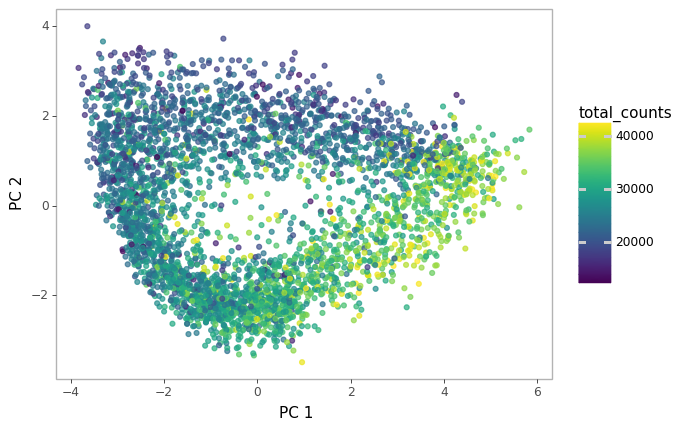

<ggplot: (8768113284982)>

In [9]:
cc.pl.cell_cycle_pca(chla9)

From this image, we can clearly see the trajectory, but also the effect of the partition counts normalization that segments the counts. We can get the trajectory from the principal elastic circle estimation using `elpigraph`, implemented in `scycle` as `tl.trajectory`:

In [10]:
cc.tl.trajectory(chla9)

Now we can look at the trajectory. We'll also plot it using the unormalized total_counts (`total_counts`). We can still see a clear gradual increase in total counts, and the sudden drop-off at the moment of cell division (around node 0-29).

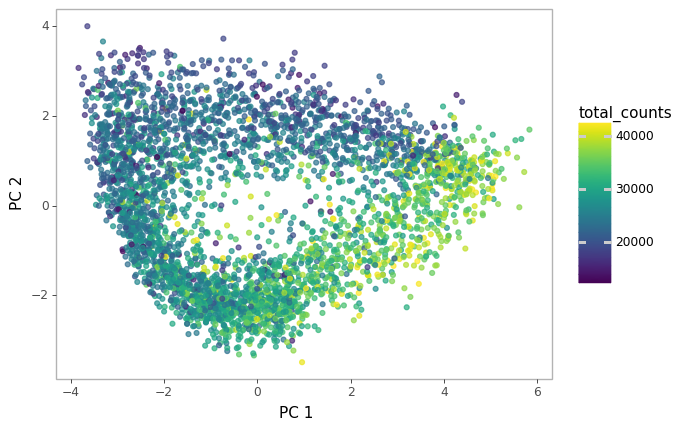

<ggplot: (8768114877968)>

In [11]:
cc.pl.cell_cycle_pca(chla9)

`tl.cell_division` will attempt to find the moment of cell division using the G2-M signature (alternatively, the `total_counts`). It will set the direction of the trajectory as the direction of increasing counts, and the moment of cell division the highest value of G2-M. In this way, we can "break" the circle into a linear trajectory, and calculate pseudotime.

Suggested moment of cell division: [27 28]
Direction of cell cycle: -1
Remapping edges using [27 28] ...


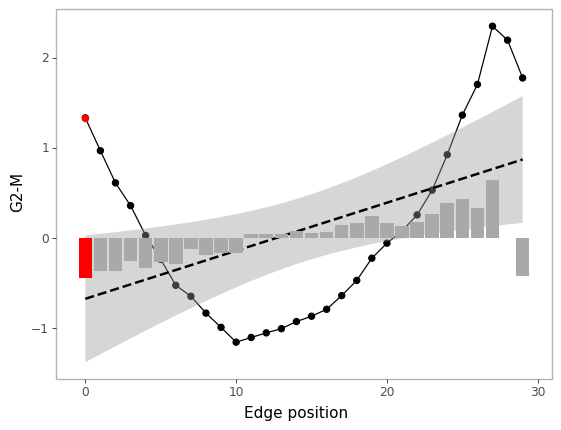

<ggplot: (8768114504662)>

In [12]:
cc.tl.cell_division(chla9)
cc.pl.cell_division(chla9)

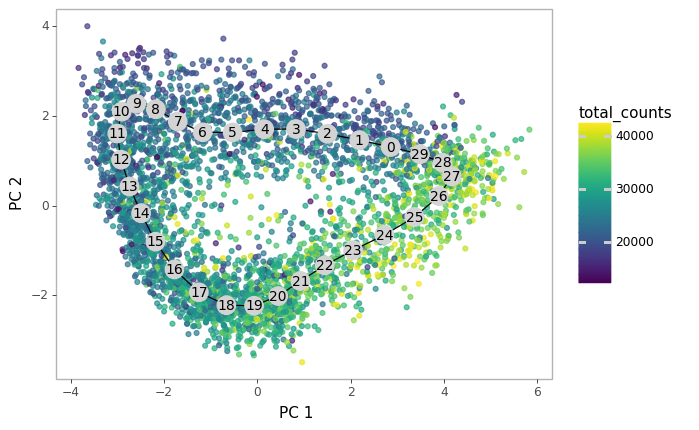

<ggplot: (8768114970426)>

In [13]:
cc.pl.cell_cycle_pca(chla9, trajectory = True)

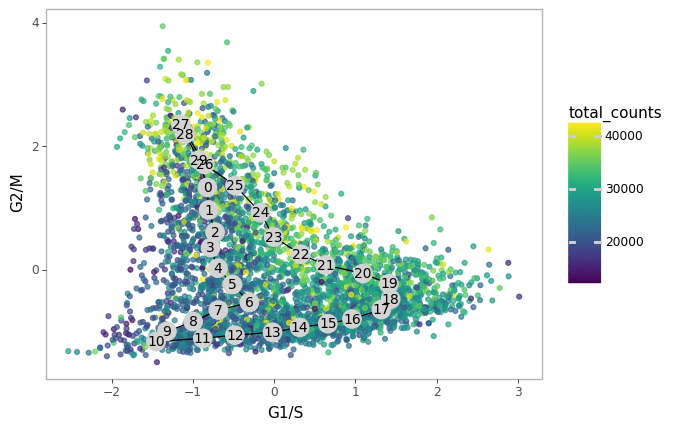

<ggplot: (8768112638449)>

In [14]:
cc.pl.cell_cycle_projection(chla9, trajectory = True)

## Pseudotime

Calculating pseudotimes for each cell...


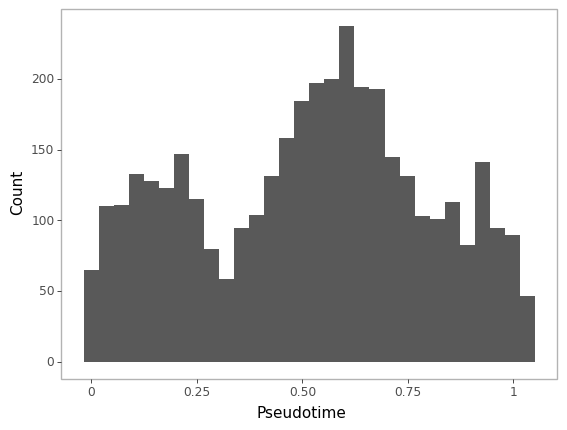

<ggplot: (8768114840980)>

In [15]:
cc.tl.pseudotime(chla9)
cc.pl.pseudotime_histogram(chla9)

We can see the distribution of cell over pseudotime, but now we can in fact plot many variables vs pseudotime in our data. For example, we can look at un-normalized counts:

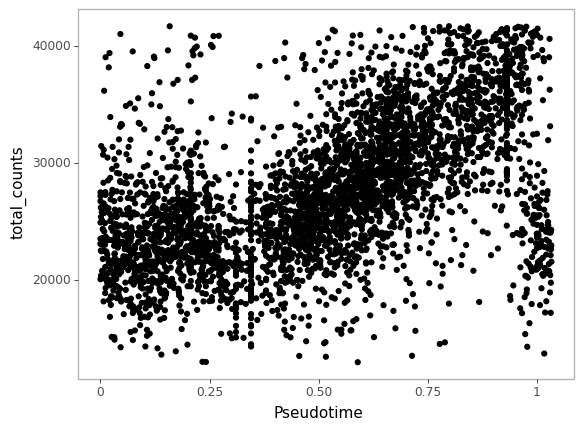

<ggplot: (8768113721929)>

In [16]:
cc.pl.pseudotime_scatter(chla9, 'total_counts')

Or the expression of some selected genes:

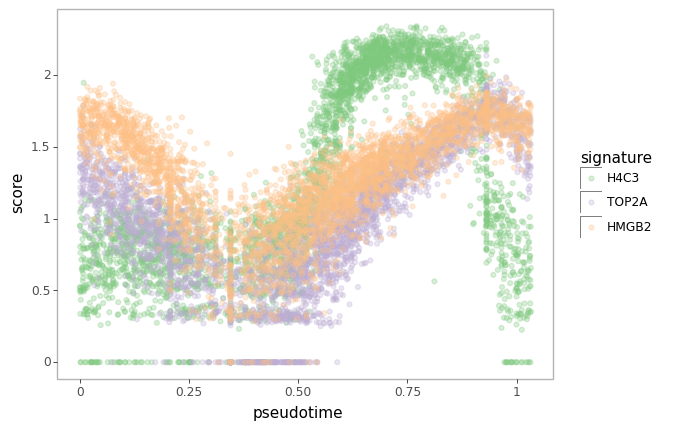

<ggplot: (8768163192206)>

In [17]:
from plotnine import scale_color_brewer
(cc.pl.pseudotime_scatter(chla9, ['H4C3', 'TOP2A', 'HMGB2'], alpha=0.3, facet = False) +
    scale_color_brewer(type = 'qual', palette = 'Accent'))

And, obviously, at the dynamics of cell cycle signatures over pseudotime. We could use `pl.pseudotime_scatter` again, but this is implemented into another call to `pl.cell_cycle_scores`.

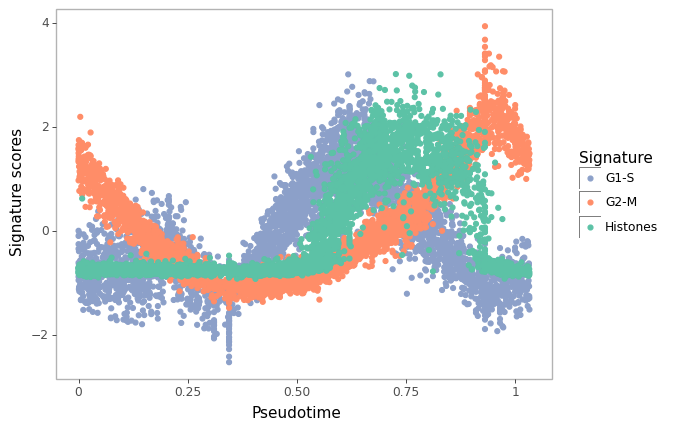

<ggplot: (8768113172830)>

In [18]:
cc.pl.cell_cycle_scores(chla9)

`tl.cell_cycle_phase` uses the curvature of the trajectory to find inflection points in the expression of genes that define the cell cycle and set boundaries between cell cycle phases. It set the boundaries at the points in the trajectory where the curvature is the highest. 

-- Suggested cell cycle division:
G1 post-mitotic:  0   - 0.3333333333333333
G1 pre-replication:  0.3333333333333333 - 0.5666666666666667
S/G2/M: 0.5666666666666667 - 1


/home/clarice/.local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_vline : Removed 1 rows containing missing values.


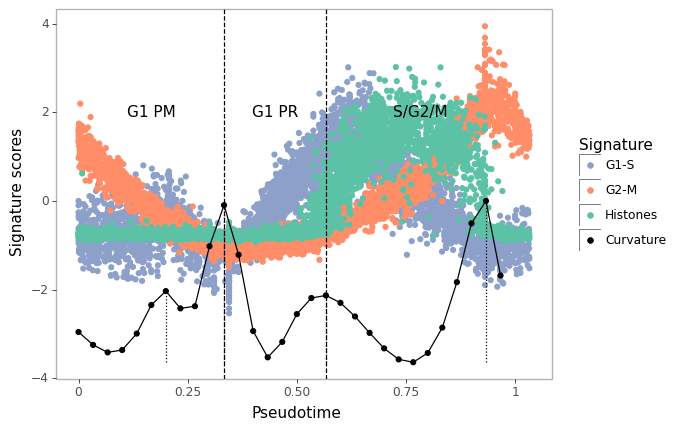

<ggplot: (8768141096283)>

In [19]:
cc.tl.cell_cycle_phase(chla9)
cc.pl.cell_cycle_scores(chla9)

/home/clarice/miniconda3/envs/scycle/lib/python3.8/site-packages/scycle/plots/_pseudotime_lineplot.py:82: UserWarning: Variable not found! Dropping: CCNA2
/home/clarice/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/clarice/.local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_vline : Removed 3 rows containing missing values.


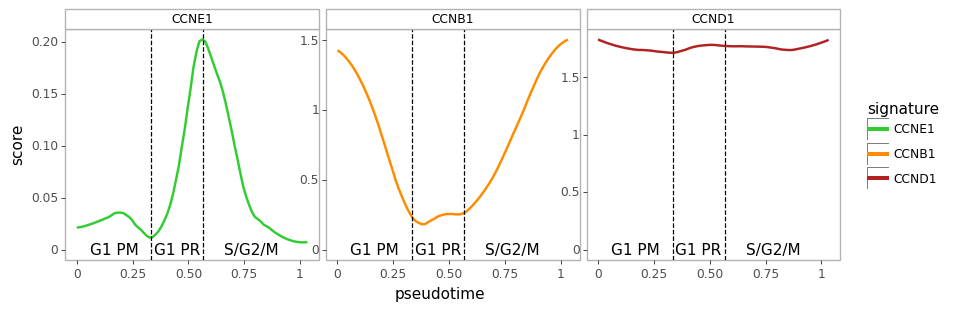

<ggplot: (8768115481113)>

In [20]:
import plotnine as p9
(cc.pl.pseudotime_lineplot(chla9, ['CCNE1', 'CCNA2', 'CCNB1', 'CCND1'], ncol = 3, lab_ypos = 0)
+ p9.scale_color_manual(values = ['limegreen', 'darkorange', 'firebrick'])
+ p9.theme(figure_size = (10,3)))

We can check how the cells were assigned into cell cycle phase 'categories' by looking at the pieplot:

([<matplotlib.patches.Wedge at 0x7f97c684daf0>,
 [Text(0.10644160139878621, 1.1450633980228615, 'S/G2/M'),
  Text(-0.9492586533724438, -0.6491594634583516, 'G1 pre-replication'),
  Text(0.7342342193851614, -0.8850989272865846, 'G1 post-mitotic')],
 [Text(0.050906852842897754, 0.5476390164457163, '47.0%'),
  Text(-0.4539932690042122, -0.31046756948008114, '25.0%'),
  Text(0.3511554962276858, -0.42330818261532305, '28.0%')])

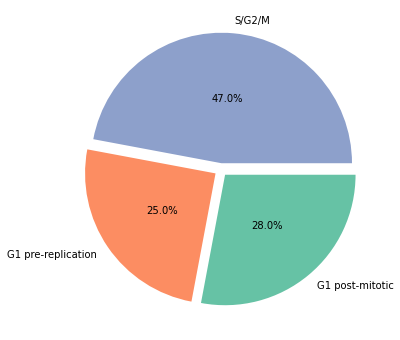

In [21]:
cc.pl.cell_cycle_phase_pieplot(chla9)

or plotting using our friend `pl.cell_cycle_pca` setting `col_var = 'cell_cycle_phase'`:

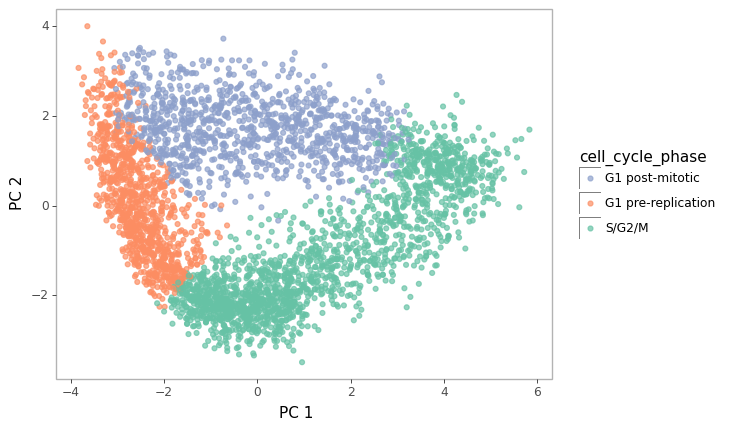

<ggplot: (8768115437794)>

In [22]:
from plotnine import scale_color_manual
(cc.pl.cell_cycle_pca(chla9, 'cell_cycle_phase') 
 + scale_color_manual(values = ['#8da0cb', '#fc8d62', '#66c2a5']))

## Cell cycle and RNA velocity

As `scycle` is built on top of AnnData, it is compatible with many other Python libraries that are built on the same platform, such as `scanpy` and `scvelo`. Since our example was loaded from a `loom` file, we have access to the unspliced and spliced matrices, and can look at RNA velocity in the cell cycle space

In [23]:
import scvelo as sv
sv.pp.moments(chla9)
sv.tl.velocity(chla9)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [24]:
sv.tl.velocity_graph(chla9)

computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_dimRed', embedded velocity vectors (adata.obsm)


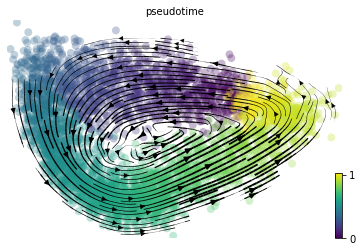

In [25]:
sv.pl.velocity_embedding_stream(chla9, basis = 'X_dimRed', color = 'pseudotime')

We can see in the stream plot a clear, orthogonal confirmation of inferred pseudotime directionality through RNA velocity.